In [1]:
import numpy as np
import pandas as pd
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
cmap = mpl.cm.get_cmap('viridis')

import itertools
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import *
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from utils.model import hill_activation, hill_activation_single, hill_activation_and

#### Promoters

In [2]:
folder = 'datasets/cleansed'
subfolder = 'promoter-permutation'
hill_params = {
    'pbad': [0.52, -0.06, 0.15, -2.06],
    'pcin': [-0.32, 0.91, 0.29, -3.11],
    'psalttc': [-0.46, 1.76, 0.29, -1.71]
}
pro_ind = {
    'ara': 'pbad',
    'ohc14': 'pcin',
    'sal': 'psalttc'
}
ind_pro = {
    'pbad': 'ara',
    'pcin': 'ohc14',
    'psalttc': 'sal'
}

In [3]:
for k in hill_params.keys():
    print(10**np.array(hill_params[k]))

[3.31131121 0.87096359 1.41253754 0.00870964]
[4.78630092e-01 8.12830516e+00 1.94984460e+00 7.76247117e-04]
[3.46736850e-01 5.75439937e+01 1.94984460e+00 1.94984460e-02]


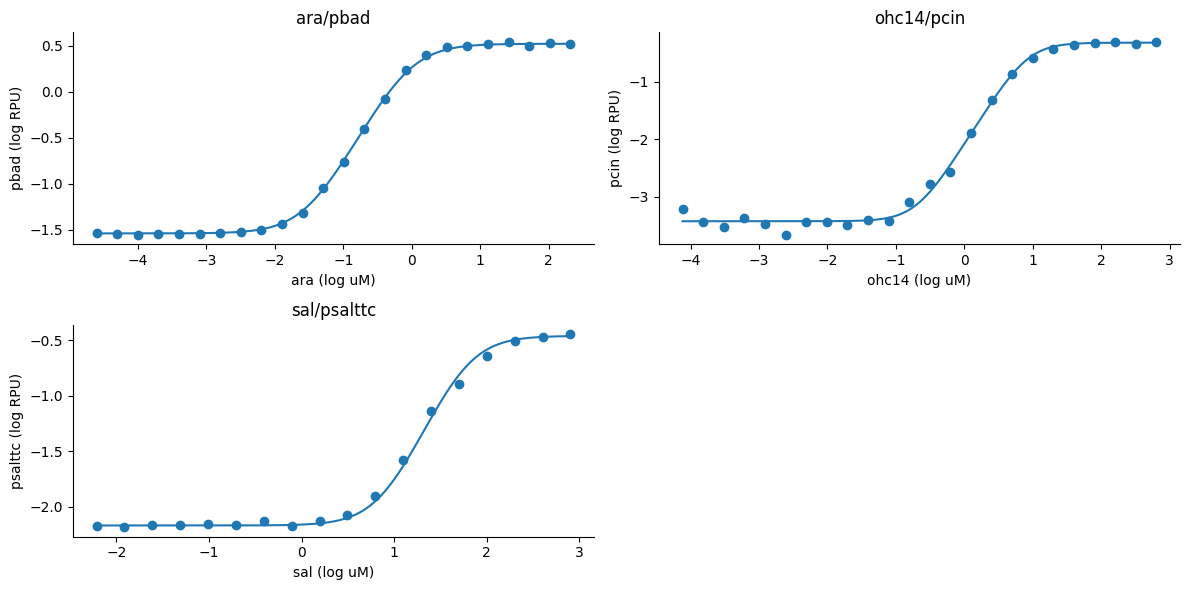

In [4]:
filename = 'promoters-jump'
promoters = pd.read_csv('{}/{}.csv'.format(folder, filename))
promoters_lbl = ['pbad', 'pcin', 'psalttc']
row, col = 2, 2
f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
for i, ax in enumerate(axs.ravel()):
    if i<len(promoters_lbl):
        p = promoters_lbl[i]
        c = ind_pro[p]
        data = np.log10(promoters[[c, p]]).dropna()
        ind_lvl = np.logspace(data[c].min(), data[c].max(), 1000)
        ax.scatter(data[c], data[p])
        ax.plot(np.log10(ind_lvl), np.log10(hill_activation_single(ind_lvl, *hill_params[p])))
        ax.set_title('{}/{}'.format(c, p))
        ax.set_xlabel('{} (log uM)'.format(c))
        ax.set_ylabel('{} (log RPU)'.format(p))
        sns.despine()
    else:
        ax.set_visible(False)
        
plt.tight_layout()

#### 2i-AND gates

In [5]:
filenames = ['PBAD-PCin-E20', 'PBAD-PSalTTC-E20', 'PCin-PSalTTC-E20', 'PCin-PBAD-E20', 'PSalTTC-PBAD-E20', 'PSalTTC-PCin-E20']

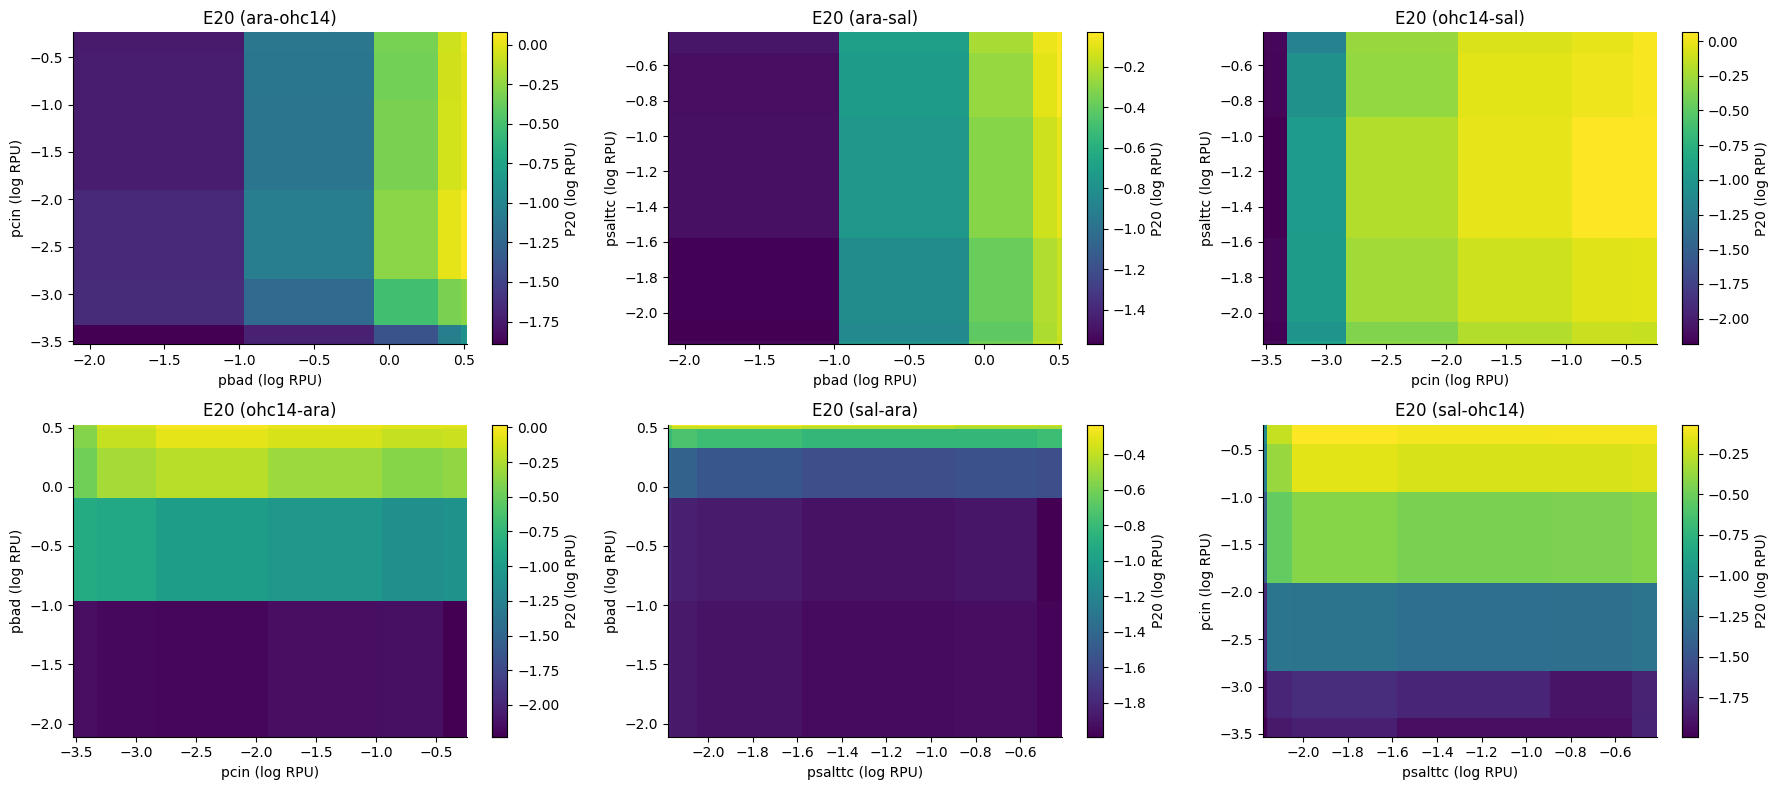

In [6]:
def plot_2d_data(filenames, title='E20', plot_type='colormesh'):

    row, col = 2, 3
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*4))
    for i, ax in enumerate(axs.ravel()):

        if i<len(filenames):

            filename = filenames[i]
            gates = pd.read_csv('{}/{}/{}.csv'.format(folder, subfolder, filename))
            ind_cols = gates.columns[:2].tolist()
            gate_cols = gates.columns[2:].tolist()
            ind_concentrations = gates[ind_cols[0]].unique(), gates[ind_cols[1]].unique()
            #first two-columns are inducers, get the RPU level from corresponding hill parameters
            for i in ind_cols:
                gates[i] = hill_activation_single(gates[i], *hill_params[pro_ind[i]])
            #the remaining columns are gates, could be one or multiple, turn them into a list and rename the fluo column
            gates_list = [gates[ind_cols+[g]].rename(columns={g:'fluo'}) for g in gate_cols]
            gates_log = [np.log10(g) for g in gates_list]
            
            #min_max = data['fluo'].min(), data['fluo'].max()
            #data['fluo'] = data['fluo'].apply(lambda x: (x-min_max[0])/(min_max[1]-min_max[0]))
            
            if plot_type=='colormesh':
                data = gates_log[0]
                p = ax.pcolormesh(data[ind_cols[0]].unique(), data[ind_cols[1]].unique(),
                                    data.pivot_table(index=ind_cols[1], columns=ind_cols[0]).values, cmap='viridis',
                                    vmin=data['fluo'].min(), vmax=data['fluo'].max())
                cbar = plt.colorbar(p, ax=ax)
                cbar.set_label('P20 (log RPU)')
                ax.set_xlabel('{} (log RPU)'.format(pro_ind[ind_cols[0]]))
                ax.set_ylabel('{} (log RPU)'.format(pro_ind[ind_cols[1]]))
            else:
                data = gates_list[0]
                sns.heatmap(data.pivot_table(index=ind_cols[1], columns=ind_cols[0]).values, cmap='viridis', ax=ax, cbar_kws={'label': 'P20 (RPU)'}).invert_yaxis()
                ax.set_xticklabels(np.round(ind_concentrations[0], 2))
                ax.set_yticklabels(np.round(ind_concentrations[1], 2))
                ax.set_xlabel('{} (uM)'.format(ind_cols[0]))
                ax.set_ylabel('{} (uM)'.format(ind_cols[1]))
            
            ax.set_title('{} ({}-{})'.format(title, *ind_cols))

            sns.despine()
            
        else:
            ax.set_visible(False)
             
    plt.tight_layout()
    
plot_2d_data(filenames)

In [7]:
def fit_model(gates, model_name='GP', y_label='fluo', scale='log'):
    
    if scale=='log':
        gates_ = [np.log10(g) for g in gates]
    else:
        gates_ = gates.copy()
    
    models = []
    for gate in gates_:
        X = gate.drop(y_label, axis=1)
        y = gate[y_label]
        if model_name=='GP':
            model = gp.GaussianProcessRegressor()
        elif model_name=='GP+Noise':
            model = gp.GaussianProcessRegressor(kernel=WhiteKernel() + RBF(1, "fixed"))
        elif model_name=='NN':
            model = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(300, 300))
        
        model.fit(X, y)
        models.append(model)
        
    return models

In [8]:
def plot_decompose(model, data, title='E20', model_name='NN', scale='log', show_interval=False):
    
    if scale=='log':
        data = np.log10(data)
    
    #setup bounds for model
    inducers_lbl = data.columns[:2].tolist()
    i1 = data[inducers_lbl[0]].unique()
    i2 = data[inducers_lbl[1]].unique()
    #if data is already in log-scale, then the model is generated in linear-scale
    ind1 = np.linspace(i1.min(), i1.max(), 1000)
    ind2 = np.linspace(i2.min(), i2.max(), 1000)
    
    row, col = 1, 2
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*4))
    ax = axs.ravel()

    fixed = inducers_lbl[0]
    varied = inducers_lbl[1]
    
    #prediction
    pred_data = pd.DataFrame(itertools.product(i1, ind2), columns=inducers_lbl)
    if show_interval:
        pred_data['fluo'], pred_data['fluo_std'] = model.predict(pred_data, return_std=True)
    else:
        pred_data['fluo'] = model.predict(pred_data)
        
    num_col_palette = len(data[fixed].unique())-1
    for x, i in enumerate(data[fixed].unique()):
        
        act = data[data[fixed]==i]
        ax[0].scatter(act[varied], act['fluo'], color=cmap(x/num_col_palette))
        pred = pred_data[pred_data[fixed]==i]
        ax[0].plot(pred[varied], pred['fluo'], color=cmap(x/num_col_palette), label=np.round(i, 2))
        if show_interval:
            ax[0].fill_between(
                pred[varied],
                pred['fluo'] - 1.96 * pred['fluo_std'],
                pred['fluo'] + 1.96 * pred['fluo_std'],
                alpha=0.2,
                color=cmap(x/num_col_palette)
            )
    ax[0].set_xlabel('{} (log RPU)'.format(pro_ind[varied]))
    ax[0].set_ylabel('P20 (log RPU)')
    ax[0].legend(title='{} (log RPU)'.format(pro_ind[fixed]), loc='center', bbox_to_anchor=(0.5, 1.15), ncol=int(len(i2)/1))

    fixed = inducers_lbl[1]
    varied = inducers_lbl[0]
    
    pred_data = pd.DataFrame(itertools.product(ind1, i2), columns=inducers_lbl)
    if show_interval:
        pred_data['fluo'], pred_data['fluo_std'] = model.predict(pred_data, return_std=True)
    else:
        pred_data['fluo'] = model.predict(pred_data)
    
    num_col_palette = len(data[fixed].unique())-1
    for x, i in enumerate(data[fixed].unique()):
        
        act = data[data[fixed]==i]
        ax[1].scatter(act[varied], act['fluo'], color=cmap(x/num_col_palette))
        
        pred = pred_data[pred_data[fixed]==i]
        ax[1].plot(pred[varied], pred['fluo'], color=cmap(x/num_col_palette), label=np.round(i, 2))
        if show_interval:
            ax[1].fill_between(
                pred[varied],
                pred['fluo'] - 1.96 * pred['fluo_std'],
                pred['fluo'] + 1.96 * pred['fluo_std'],
                alpha=0.2,
                color=cmap(x/num_col_palette)
            )
    ax[1].set_xlabel('{} (log RPU)'.format(pro_ind[varied]))
    ax[1].set_ylabel('P20 (log RPU)')
    ax[1].legend(title='{} (log RPU)'.format(pro_ind[fixed]), loc='center', bbox_to_anchor=(0.5, 1.15), ncol=int(len(i2)/1))

    plt.suptitle('{} ({}-{})'.format(title, *inducers_lbl))
    plt.tight_layout()
    sns.despine()

Training a model.

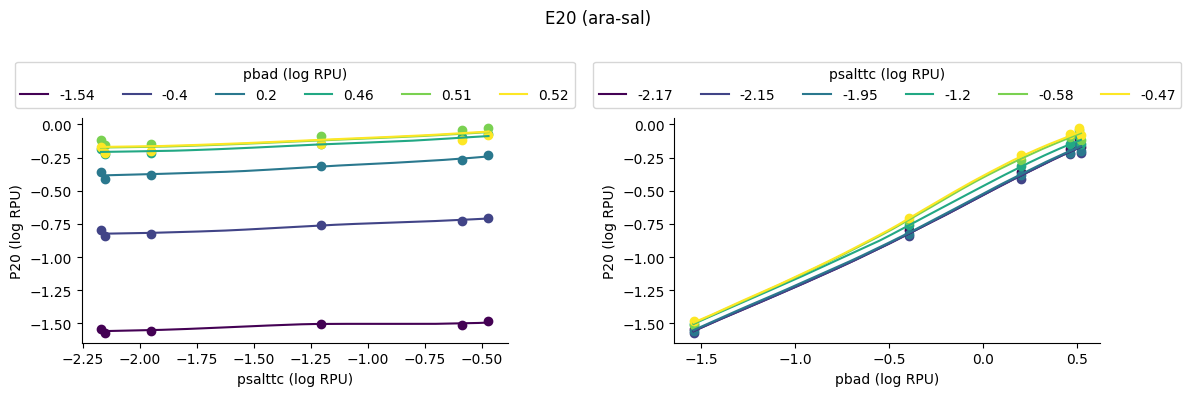

In [17]:
filename = 'PBAD-PSalTTC-E20'
model_name = 'NN'
gates = pd.read_csv('{}/{}/{}.csv'.format(folder, subfolder, filename))
ind_cols = gates.columns[:2].tolist()
gate_cols = gates.columns[2:].tolist()
#first two-columns are inducers, get the RPU level from corresponding hill parameters
for i in ind_cols:
    gates[i] = hill_activation_single(gates[i], *hill_params[pro_ind[i]])
#the remaining columns are gates, could be one or multiple, turn them into a list and rename the fluo column
gates_list = [gates[ind_cols+[g]].rename(columns={g:'fluo'}) for g in gate_cols]
#gates_log = [np.log10(g) for g in gates_list]
models = fit_model(gates_list, model_name=model_name)

plot_decompose(models[0], gates_list[0], model_name=model_name, show_interval=False)

Making prediction.

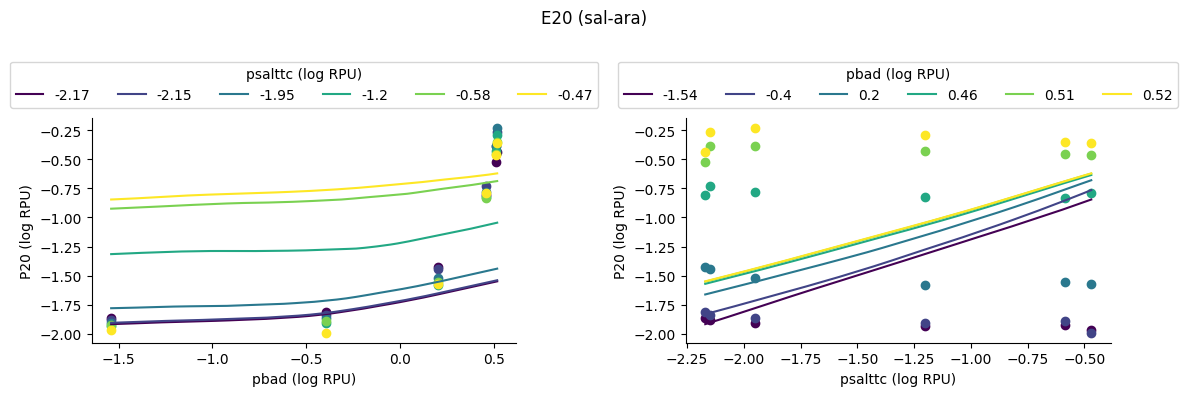

In [18]:
filename = 'PSalTTC-PBAD-E20'
gates = pd.read_csv('{}/{}/{}.csv'.format(folder, subfolder, filename))
ind_cols = gates.columns[:2].tolist()
gate_cols = gates.columns[2:].tolist()
#first two-columns are inducers, get the RPU level from corresponding hill parameters
for i in ind_cols:
    gates[i] = hill_activation_single(gates[i], *hill_params[pro_ind[i]])
#the remaining columns are gates, could be one or multiple, turn them into a list and rename the fluo column
gates_list = [gates[ind_cols+[g]].rename(columns={g:'fluo'}) for g in gate_cols]

plot_decompose(models[0], gates_list[0], model_name=model_name, show_interval=False)

In [ ]:
filename = '076-077-2i-AND-gates-optimized-5-dilutions'
model_name = 'GP'
gates = pd.read_csv('{}/2i-AND-gates/{}.csv'.format(folder, filename))
gates['ara'] = hill_activation_single(gates['ara'], *hill_params['pbad'])
gates['ohc14'] = hill_activation_single(gates['ohc14'], *hill_params['pcin'])
gate_list = [gates[['ara', 'ohc14', g]].rename(columns={'ara': 'Ara', 'ohc14': 'OHC14', g: 'fluo'}) for g in gates.columns[2:]]
gate_list_log = [np.log10(gate) for gate in gate_list]
models = fit_2d_gates(gate_list_log, model_name=model_name)
plot_2d(models[0], gate_list[0], ['Ara', 'OHC14'], 'E20', True)

In [ ]:
plot_2d(models[1], gate_list[1], ['Ara', 'OHC14'], 'E38', True)

Predicting max-min induction

In [ ]:
inducer_minmax = {
    'ara': [0, 13], 'ohc14': [0, 10], 'sal': [0, 100]
}
gate_minmax = pd.read_csv('{}/permutation-promoters.csv'.format(folder))

In [ ]:
gate_list = ['PBAD-PCin-E20', 'PBAD-PSalTTC-E20', 'PCin-PSalTTC-E20',
        'PCin-PBAD-E20', 'PSalTTC-PBAD-E20', 'PSalTTC-PCin-E20']
inds_list = [['ara', 'ohc14'], ['ara', 'sal'], ['ohc14', 'sal'],
        ['ohc14', 'ara'], ['sal', 'ara'], ['sal', 'ohc14']]

row, col = 2, 3
f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))

for i, ax in enumerate(axs.ravel()):

    gate = gate_list[i]
    inds = inds_list[i]
    data = gate_minmax[['Inducer1', 'Inducer2']+[col for col in gate_minmax if col.startswith(gate)]]
    data['experiment'] = data.iloc[:,2:].mean(axis=1)
    data['std'] = data.iloc[:,2:].std(axis=1).fillna(0)
    data['Inducer1'] = data['Inducer1'].apply(lambda x: inducer_minmax[inds[0]][x])
    data['Inducer2'] = data['Inducer2'].apply(lambda x: inducer_minmax[inds[1]][x])
    data[inds[0]] = hill_activation_single(pbadpcin['Inducer1'], *hill_params[prom_ind[inds[0]]])
    data[inds[1]] = hill_activation_single(pbadpcin['Inducer2'], *hill_params[prom_ind[inds[1]]])
    data_log = np.log10(data[[inds[0], inds[1], 'experiment']])
    data_log['prediction'] = models[0].predict(data_log[[inds[0], inds[1]]])

    sns.set_palette('viridis', n_colors=2)
    bardata = (10**data_log).melt(id_vars=[inds[0], inds[1]])
    bardata['idx'] = ['00', '01', '10', '11', '00', '01', '10', '11']
    sns.barplot(data=bardata, x='idx', y='value', hue='variable', ax=ax)
    ax.set_xlabel('Induction states')
    ax.set_ylabel('P20 (RPU)')
    ax.set_title(gate)
    ax.legend(loc=2, title=None)
    sns.despine()
    
plt.tight_layout()

In [ ]:
gate_list = ['PBAD-PCin-E38', 'PBAD-PSalTTC-E38', 'PCin-PSalTTC-E38',
        'PCin-PBAD-E38', 'PSalTTC-PBAD-E38', 'PSalTTC-PCin-E38']
inds_list = [['ara', 'ohc14'], ['ara', 'sal'], ['ohc14', 'sal'],
        ['ohc14', 'ara'], ['sal', 'ara'], ['sal', 'ohc14']]

row, col = 2, 3
f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))

for i, ax in enumerate(axs.ravel()):

    gate = gate_list[i]
    inds = inds_list[i]
    data = gate_minmax[['Inducer1', 'Inducer2']+[col for col in gate_minmax if col.startswith(gate)]]
    data['experiment'] = data.iloc[:,2:].mean(axis=1)
    data['std'] = data.iloc[:,2:].std(axis=1).fillna(0)
    data['Inducer1'] = data['Inducer1'].apply(lambda x: inducer_minmax[inds[0]][x])
    data['Inducer2'] = data['Inducer2'].apply(lambda x: inducer_minmax[inds[1]][x])
    data[inds[0]] = hill_activation_single(pbadpcin['Inducer1'], *hill_params[prom_ind[inds[0]]])
    data[inds[1]] = hill_activation_single(pbadpcin['Inducer2'], *hill_params[prom_ind[inds[1]]])
    data_log = np.log10(data[[inds[0], inds[1], 'experiment']])
    data_log['prediction'] = models[1].predict(data_log[[inds[0], inds[1]]])

    sns.set_palette('viridis', n_colors=2)
    bardata = (10**data_log).melt(id_vars=[inds[0], inds[1]])
    bardata['idx'] = ['00', '01', '10', '11', '00', '01', '10', '11']
    sns.barplot(data=bardata, x='idx', y='value', hue='variable', ax=ax)
    ax.set_xlabel('Induction states')
    ax.set_ylabel('P38 (RPU)')
    ax.set_title(gate)
    ax.legend(loc=2, title=None)
    sns.despine()
    
plt.tight_layout()

In [25]:
def plot_1d(model, data, inducers_lbl, title):
    
    i1 = data[inducers_lbl[0]].unique()
    i2 = data[inducers_lbl[1]].unique()
    ind1 = np.logspace(np.log10(i1.min()), np.log10(i1.max()), 1000)
    ind2 = np.logspace(np.log10(i2.min()), np.log10(i2.max()), 1000)

    act_data = np.log10(data)
    act_data['pred'] = model.predict(act_data[inducers_lbl])
    #print(act_data)

    inducers = [ind1, ind2]
    pred_data = pd.DataFrame(itertools.product(*inducers))
    pred_data.columns = inducers_lbl
    pred_data = np.log10(pred_data)
    pred_data['prediction'] = model.predict(pred_data)
    #print(pred_data)
    
    plt.figure(figsize=[8, 6])
    
    length = len(pred_data[inducers_lbl[0]].unique())
    p1 = plt.pcolormesh(pred_data[inducers_lbl[0]].unique(), pred_data[inducers_lbl[1]].unique(),
                        pred_data.pivot_table(index=inducers_lbl[1], columns=inducers_lbl[0]).values, cmap='viridis',
                        vmin=pred_data['prediction'].min(), vmax=pred_data['prediction'].max())
    p2 = plt.scatter(act_data[inducers_lbl[0]], act_data[inducers_lbl[1]],
                     c=act_data['fluo'], edgecolors='black', s=200, cmap='viridis',
                     vmin=pred_data['prediction'].min(), vmax=pred_data['prediction'].max())    
    
    plt.xlabel('{} (log RPU)'.format(inducers_lbl[0]))
    plt.ylabel('{} (log RPU)'.format(inducers_lbl[1]))
    cbar1 = plt.colorbar(p1)
    cbar2 = plt.colorbar(p2)
    cbar1.set_label('P20 model (log RPU)')
    cbar2.set_label('P20 experiment (log RPU)')
    plt.title('{} ({}-{})'.format(title, *inducers_lbl))
    
    plt.tight_layout()
    sns.despine()

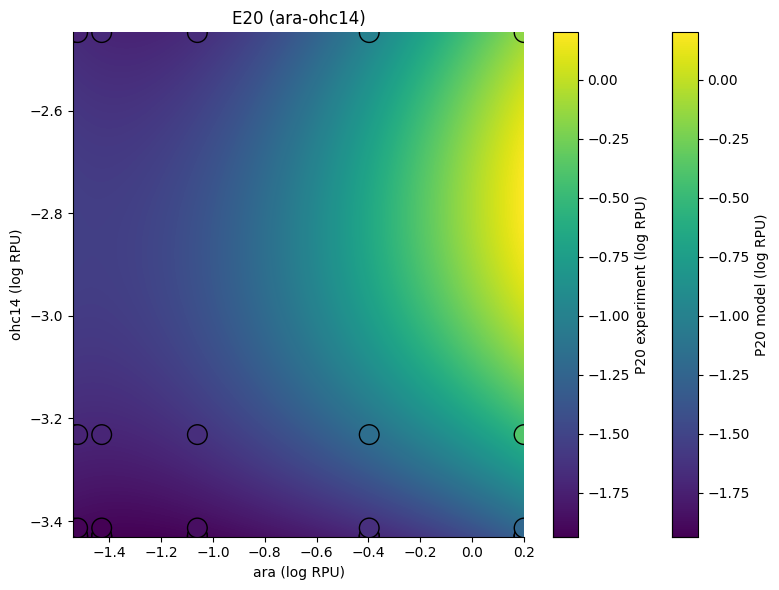

In [26]:
plot_1d(models[0], gates_list[0], ind_cols, 'E20')

In [ ]:
ara_3 = np.array([0, 0.0808, 0.3204, 13])
ohc14_3 = np.array([0, 609, 2.065, 10])
sal_3 = np.array([0, 9.618, 19.02, 36.135, 100])
ara_rpu = hill_activation_single(ara_3, *hill_params['pbad'])
ohc14_rpu = hill_activation_single(ohc14_3, *hill_params['pcin'])
sal_rpu = hill_activation_single(sal_3, *hill_params['psalttc'])

In [ ]:
gate_lin = 10**gate
for i, o in enumerate(gate_lin['OHC14'].unique()):
    gate_ara = gate_lin[gate_lin['OHC14']==o].reset_index(drop=True)
    plt.plot(gate_ara.index, gate_ara['fluo'])

In [ ]:
gate_lin = 10**gate
for i, o in enumerate(gate_lin['Ara'].unique()):
    gate_ara = gate_lin[gate_lin['Ara']==o].reset_index(drop=True)
    plt.plot(gate_ara.index, gate_ara['fluo'])

In [ ]:
plot_2d(model1, 10**gate, ['Ara', 'OHC14'], g, False)

In [ ]:
g = 'E38'
gate = gates_log[['ara', 'ohc14', g]].rename(columns={g: 'fluo'})
X = gate.drop('fluo', axis=1)
y = gate['fluo']
model2 = gp.GaussianProcessRegressor()
model2.fit(X, y)

In [ ]:
ind = ['Ara', 'OHC14']
ori_gate = 10**gate
i1 = ori_gate[ind[0]].unique()
i2 = ori_gate[ind[1]].unique()
ind1 = np.logspace(np.log10(i1.min()), np.log10(i1.max()), 100)
ind2 = np.logspace(np.log10(i2.min()), np.log10(i2.max()), 100)

inducers = [ind1, ind2]
pred_data = pd.DataFrame(itertools.product(*inducers))
pred_data.columns = ['ara', 'ohc14']
pred_data = np.log10(pred_data)
pred_data['fluo'] = model1.predict(pred_data)

p = sns.heatmap(pred_data.pivot_table(index='ara', columns='ohc14').T, cmap='viridis')
p.invert_yaxis()

plt.show()

In [ ]:
gate.pivot_table(index='Ara', columns='OHC14')

In [ ]:
p = sns.heatmap(gate.pivot_table(index='Ara', columns='OHC14').T, cmap='viridis')
#plt.colorbar(p)
p.invert_yaxis()
plt.show()

In [ ]:
plot_1d(model1, 10**gate, ['ara', 'ohc14'], g)

In [19]:
ara_3 = np.array([0, 0.0808, 0.3204, 13])
ohc14_3 = np.array([0, 609, 2.065, 10])
sal_3 = np.array([0, 9.618, 19.02, 36.135, 100])
ara_rpu = hill_activation_single(ara_3, *hill_params['pbad'])
ohc14_rpu = hill_activation_single(ohc14_3, *hill_params['pcin'])
sal_rpu = hill_activation_single(sal_3, *hill_params['psalttc'])

In [20]:
inducers_dict = {
    'Ara': hill_activation_single(np.array([0, 0.0808, 0.3204, 208]), *hill_params['pbad']),
    'OHC14': hill_activation_single(np.array([0, 609, 2.065, 40]), *hill_params['pcin']),
    'Sal': hill_activation_single(np.array([0, 9.618, 19.02, 36.135, 400]), *hill_params['psalttc']),
}

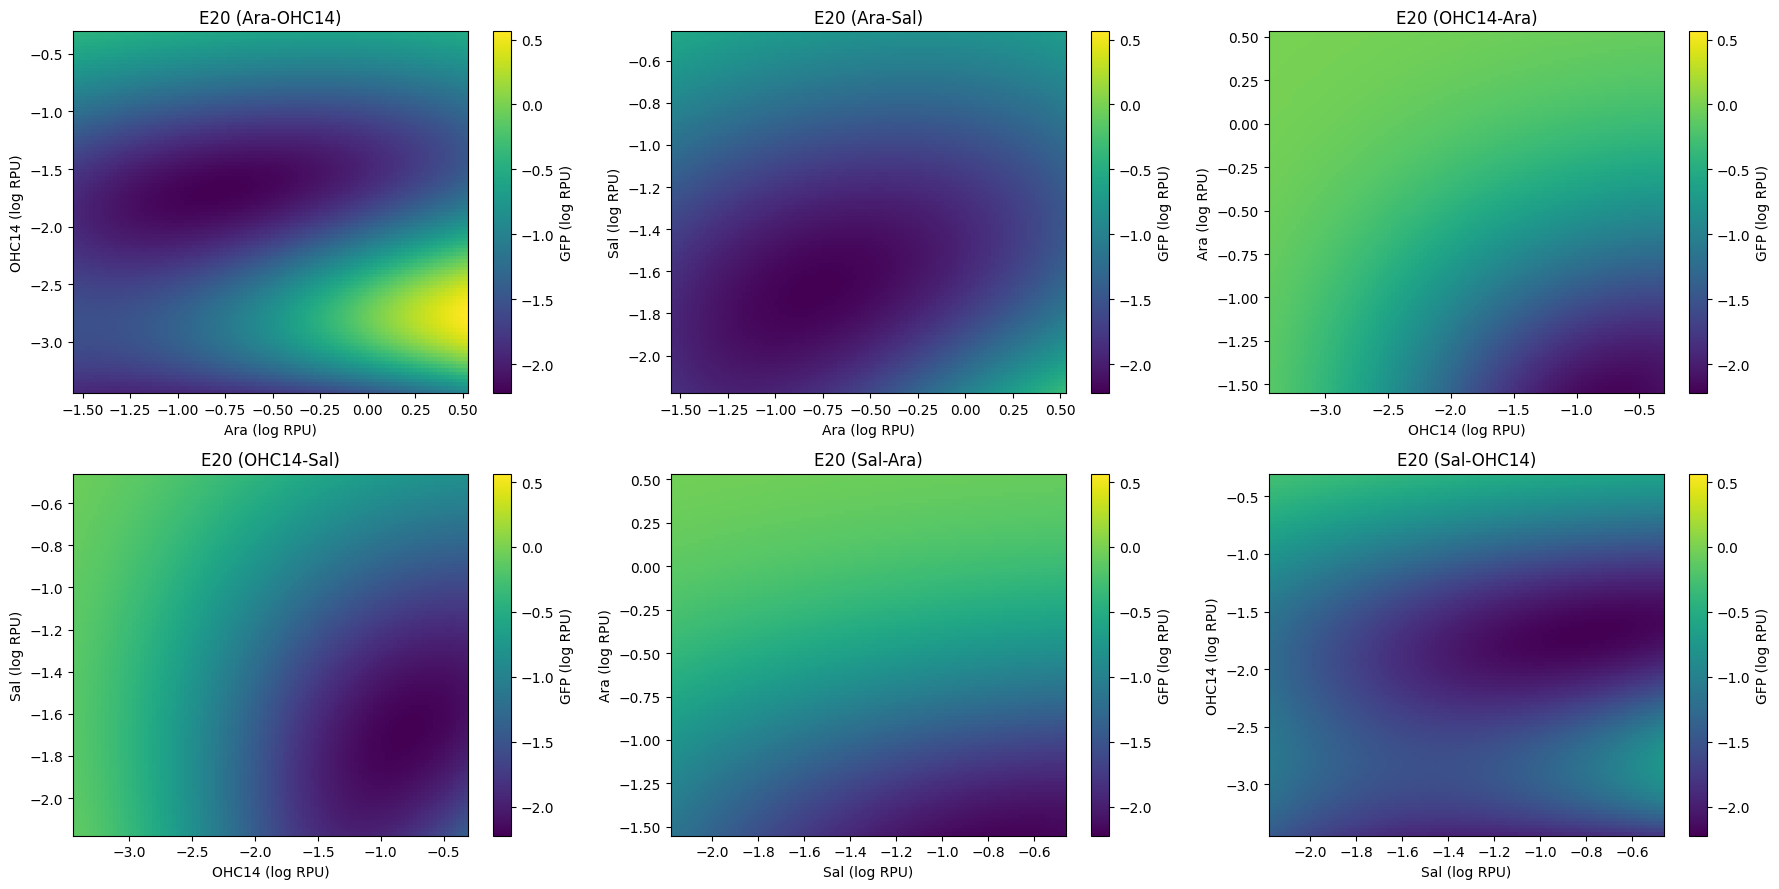

In [21]:
def plot_predict_3d(ind_dict, ind_lbls, model, gate_title, show_interval=False):
    
    predictions = []
    global_min, global_max = [], []
    for i, (ind1_lbl, ind2_lbl) in enumerate(list(itertools.permutations(ind_lbls, 2))):
        
        i1 = ind_dict[ind1_lbl]
        i2 = ind_dict[ind2_lbl]
        
        #setup bounds for model
        ind1 = np.logspace(np.log10(i1.min()), np.log10(i1.max()), 100)
        ind2 = np.logspace(np.log10(i2.min()), np.log10(i2.max()), 100)

        inducers = [ind1, ind2]
        pred_data = pd.DataFrame(itertools.product(*inducers))
        pred_data.columns = [ind1_lbl, ind2_lbl]
        pred_data = np.log10(pred_data)
        pred_data['prediction'] = model.predict(pred_data)
        
        predictions.append(pred_data)
        global_min.append(pred_data['prediction'].min())
        global_max.append(pred_data['prediction'].max())

    row, col = 2, 3
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*4.5))
    axr = axs.ravel()
    
    for i, (ind1_lbl, ind2_lbl) in enumerate(list(itertools.permutations(ind_lbls, 2))):
        
        pred_data = predictions[i]

        length = len(pred_data[ind1_lbl].unique())
        p = axr[i].pcolormesh(pred_data[ind1_lbl].unique(), pred_data[ind2_lbl].unique(),
                            pred_data.pivot_table(index=ind2_lbl, columns=ind1_lbl).values, cmap='viridis',
                            vmin=min(global_min), vmax=max(global_max)) 

        axr[i].set_xlabel('{} (log RPU)'.format(ind1_lbl))
        axr[i].set_ylabel('{} (log RPU)'.format(ind2_lbl))
        cbar = plt.colorbar(p, ax=axr[i])
        cbar.set_label('GFP (log RPU)')
        axr[i].set_title('{} ({}-{})'.format(gate_title, ind1_lbl, ind2_lbl))

    plt.tight_layout()
    plt.show()
    
plot_predict_3d(inducers_dict, ['Ara', 'OHC14', 'Sal'], models[0], 'E20')

In [22]:
plot_predict_3d(inducers_dict, ['Ara', 'OHC14', 'Sal'], models[1], 'E38')

IndexError: list index out of range

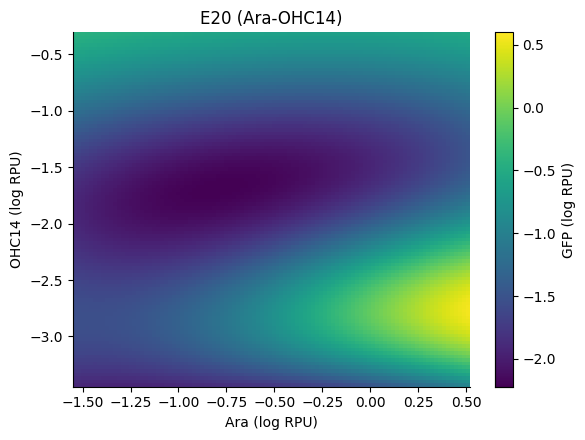

In [23]:
def plot_predict_1d(i1, i2, model, gate_title, ind1_lbl='Ara', ind2_lbl='OHC14', show_interval=False):
    
    #setup bounds for model
    ind1 = np.logspace(np.log10(i1.min()), np.log10(i1.max()), 100)
    ind2 = np.logspace(np.log10(i2.min()), np.log10(i2.max()), 100)
    
    inducers = [ind1, ind2]
    pred_data = pd.DataFrame(itertools.product(*inducers))
    pred_data.columns = ['ara', 'ohc14']
    pred_data = np.log10(pred_data)
    pred_data['prediction'] = model.predict(pred_data)
    #print(pred_data)
    
    plt.figure(figsize=[6, 4.5])
    
    length = len(pred_data['ara'].unique())
    p1 = plt.pcolormesh(pred_data['ara'].unique(), pred_data['ohc14'].unique(),
                        pred_data.pivot_table(index='ohc14', columns='ara').values, cmap='viridis',
                        vmin=pred_data['prediction'].min(), vmax=0.6) 
    
    plt.xlabel('{} (log RPU)'.format(ind1_lbl))
    plt.ylabel('{} (log RPU)'.format(ind2_lbl))
    cbar = plt.colorbar(p1)
    cbar.set_label('GFP (log RPU)')
    plt.title('{} ({}-{})'.format(gate_title, ind1_lbl, ind2_lbl))
    
    plt.tight_layout()
    sns.despine()
    
plot_predict_1d(ara_rpu, ohc14_rpu, models[0], 'E20', 'Ara', 'OHC14')

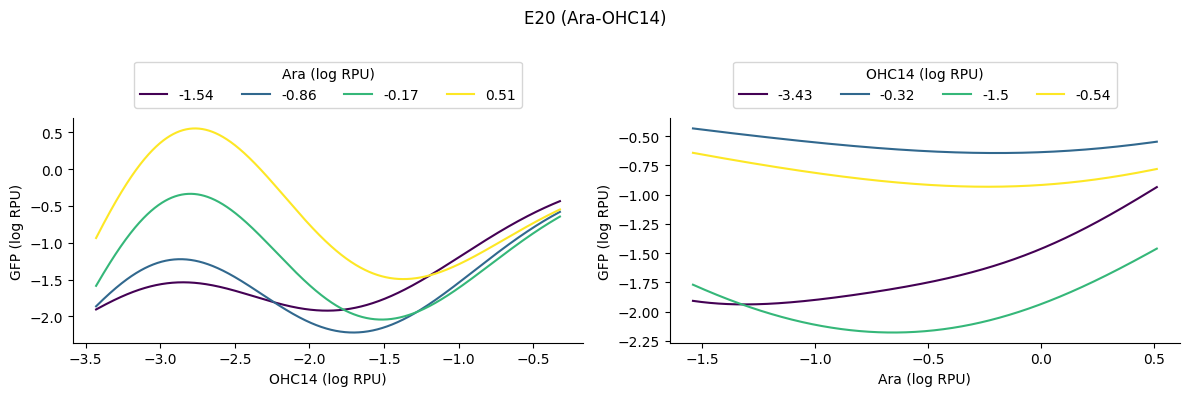

In [24]:
def plot_predict_2d(i1, i2, model1, gate_title, ind1_lbl='Ara', ind2_lbl='OHC14', show_interval=False):
    
    #setup bounds for model
    ind1 = np.logspace(np.log10(i1.min()), np.log10(i1.max()), 1000)
    ind2 = np.logspace(np.log10(i2.min()), np.log10(i2.max()), 1000)
    
    row, col = 1, 2
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*4))
    axr = axs.ravel()

    fixed = ind1_lbl
    varied = ind2_lbl

    #prediction
    inducers = [i1, ind2]
    pred_data = pd.DataFrame(itertools.product(*inducers))
    pred_data.columns = [ind1_lbl, ind2_lbl]
    pred_data = np.log10(pred_data)
    #prediction is in logscale
    if show_interval:
        pred_data['fluo'], pred_data['fluo_std'] = model1.predict(pred_data, return_std=True)
    else:
        pred_data['fluo'] = model1.predict(pred_data)


    num_col_palette = len(i1)-1
    for x, i in enumerate(np.log10(i1)):

        pred = pred_data[pred_data[fixed]==i]
        axr[0].plot(pred[varied], pred['fluo'], color=cmap(x/num_col_palette), label=np.round(i, 2))
        if show_interval:
            axr[0].fill_between(
                pred[varied],
                pred['fluo'] - 1.96 * pred['fluo_std'],
                pred['fluo'] + 1.96 * pred['fluo_std'],
                alpha=0.2,
                color=cmap(x/num_col_palette)
            )
    axr[0].set_xlabel('{} (log RPU)'.format(varied))
    axr[0].set_ylabel('GFP (log RPU)')
    axr[0].legend(title='{} (log RPU)'.format(fixed), loc='center', bbox_to_anchor=(0.5, 1.15), ncol=len(i2))
    #axr[0].set_xscale('log')
    #axr[0].set_yscale('log')

    fixed = ind2_lbl
    varied = ind1_lbl

    inducers = [ind1, i2]
    pred_data = pd.DataFrame(itertools.product(*inducers))
    pred_data.columns = [ind1_lbl, ind2_lbl]
    pred_data = np.log10(pred_data)
    if show_interval:
        pred_data['fluo'], pred_data['fluo_std'] = model1.predict(pred_data, return_std=True)
    else:
        pred_data['fluo'] = model1.predict(pred_data)

    num_col_palette = len(i2)-1
    for x, i in enumerate(np.log10(i2)):

        pred = pred_data[pred_data[fixed]==i]
        axr[1].plot(pred[varied], pred['fluo'], color=cmap(x/num_col_palette), label=np.round(i, 2))
        if show_interval:
            axr[1].fill_between(
                pred[varied],
                pred['fluo'] - 1.96 * pred['fluo_std'],
                pred['fluo'] + 1.96 * pred['fluo_std'],
                alpha=0.2,
                color=cmap(x/num_col_palette)
            )
    axr[1].set_xlabel('{} (log RPU)'.format(varied))
    axr[1].set_ylabel('GFP (log RPU)')
    axr[1].legend(title='{} (log RPU)'.format(fixed), loc='center', bbox_to_anchor=(0.5, 1.15), ncol=len(i2))
    #axr[1].set_xscale('log')
    #axr[1].set_yscale('log')
    plt.suptitle('{} ({}-{})'.format(gate_title, ind1_lbl, ind2_lbl))
    plt.tight_layout()
    sns.despine()
    
plot_predict_2d(ara_rpu, ohc14_rpu, models[0], 'E20', 'Ara', 'OHC14', False)

In [ ]:
plot_predict_2d(ara_rpu, sal_rpu, models[0], 'E20', 'Ara', 'Sal', False)

In [ ]:
plot_predict_2d(ohc14_rpu, ara_rpu, models[0], 'E20', 'OHC14', 'Ara', False)

In [ ]:
plot_predict_2d(ohc14_rpu, sal_rpu, models[0], 'E20', 'OHC14', 'Sal', False)

In [ ]:
plot_predict_2d(sal_rpu, ara_rpu, models[0], 'E20', 'Sal', 'Ara', False)

In [ ]:
plot_predict_2d(sal_rpu, ohc14_rpu, models[0], 'E20', 'Sal', 'OHC14', False)

In [ ]:
plt.pcolormesh(X['ara'].unique(), X['ohc14'].unique(), model1.predict(X).reshape(5, 5))
plt.scatter(X['ara'], X['ohc14'])
plt.show()

In [ ]:
X

In [ ]:
np.arange(rows*cols).reshape(rows, cols)

In [ ]:
cols = 5
rows = 5
#fig, ax = plt.subplots(constrained_layout=True)
Z = np.arange(rows * cols).reshape(rows, cols)
x = np.arange(cols)
y = np.arange(rows)
plt.pcolormesh(x, y, Z, shading='gouraud', vmin=Z.min(), vmax=Z.max())
plt.title('Gouraud Shading')
 
plt.show()

In [ ]:
gate_r = 10**gate
plot_2d(model, gate_r, ['ara', 'ohc14'], 'ECF38-GP(RBF Kernel)', True)

In [ ]:
gates = pd.read_csv('{}/076-077-2i-AND-gates-induction-matrix-optimized-5-dilution.csv'.format(folder))
#ara = #np.array([0, 0.055, 0.161, 0.692, 13])
#ohc14 = #np.array([0, 0.436, 1.128, 2.827, 10])
gates_rpu = generate_gates_rpu(gates[['E20', 'E38']], [gates['ara'], gates['ohc14']], ['pbad', 'pcin'])
models = fit_2d_gates(gates_rpu, model_name='NN')

In [ ]:
#ara = np.array([0, 0.055, 0.161, 0.692, 13])
#ohc14 = np.array([0, 0.436, 1.128, 2.827, 10])
#ara_rpu = hill_activation_single(ara, *hill_params['pbad'])
#ohc14_rpu = hill_activation_single(ohc14, *hill_params['pcin'])

gates = pd.read_csv('{}/076-077-2i-AND-gates-induction-matrix-optimized-5-dilution.csv'.format(folder))
e20 = gates[['ara', 'ohc14', 'E20']].rename(columns={'E20': 'fluo'})#pd.concat([pd.DataFrame(itertools.product(ara_rpu, ohc14_rpu)), gates['E20']], axis=1)
#e20.columns = ['ara', 'ohc14', 'fluo']
e38 = gates[['ara', 'ohc14', 'E38']].rename(columns={'E20': 'fluo'})#pd.concat([pd.DataFrame(itertools.product(ara_rpu, ohc14_rpu)), gates['E38']], axis=1)
#e38.columns = ['ara', 'ohc14', 'fluo']
ara_rpu = hill_activation_single(e20['ara'], *hill_params['pbad'])
ohc14_rpu = hill_activation_single(e20['ohc14'], *hill_params['pcin'])

In [ ]:
plot_2d(models[1], e20, ara_rpu, ohc14_rpu, 'ECF20-GP(RBF Kernel)')

In [ ]:
sal = np.array([0, 9.618, 19.02, 36.135, 100])
sal_rpu = hill_activation_single(sal, *hill_params['psalttc'])

In [ ]:
ara_rpu, ohc14_rpu, sal_rpu

In [ ]:
ara_rpu = gates['ara'].unique()
ohc14_rpu = gates['ohc14'].unique()

In [ ]:
inducers_combo = list(itertools.permutations([ara_rpu, ohc14_rpu, sal_rpu], 2))
inducers_title_combo = list(itertools.permutations(['ara', 'ohc14', 'sal'], 2))
row, col = 2, 3
f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
axr = axs.ravel()
for i, ax in enumerate(axr):
    
    pred_data = pd.DataFrame(itertools.product(*inducers_combo[i]))
    pred_data.columns = ['ind1', 'ind2']
    pred_data = np.log10(pred_data)
    pred_data['pred'] = model1.predict(pred_data)
    ax.bar(pred_data.index, 10**pred_data['pred'])
    #ax.axhline(3/2, linestyle='--', color='gray')
    ax.set_title(inducers_title_combo[i])
    ax.set_ylim([0, 3.5])
    sns.despine()
    
plt.tight_layout()

In [ ]:
inducers_combo = list(itertools.permutations([ara_rpu, ohc14_rpu, sal_rpu], 2))
inducers_title_combo = list(itertools.permutations(['ara', 'ohc14', 'sal'], 2))
row, col = 2, 3
f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
axr = axs.ravel()
for i, ax in enumerate(axr):
    
    pred_data = pd.DataFrame(itertools.product(*inducers_combo[i]))
    pred_data.columns = ['ind1', 'ind2']
    pred_data = np.log10(pred_data)
    pred_data['pred'] = model2.predict(pred_data)
    ax.bar(pred_data.index, 10**pred_data['pred'])
    #ax.axhline(3/2, linestyle='--', color='gray')
    ax.set_title(inducers_title_combo[i])
    ax.set_ylim([0, 2.2])
    sns.despine()
    
plt.tight_layout()

In [ ]:
inducers_combo = list(itertools.permutations([ara_rpu, ohc14_rpu, sal_rpu], 2))
inducers_title_combo = list(itertools.permutations(['ara', 'ohc14', 'sal'], 2))
row, col = 2, 3
f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
axr = axs.ravel()
for i, ax in enumerate(axr):
    
    pred_data = pd.DataFrame(itertools.product(*inducers_combo[i]))
    pred_data.columns = ['ind1', 'ind2']
    pred_data = np.log10(pred_data)
    pred_data['pred'] = model1.predict(pred_data)
    
    pred_data = pred_data.sort_values(['ind2', 'ind1']).reset_index(drop=True)
    
    ax.bar(pred_data.index, 10**pred_data['pred'])
    #ax.axhline(3/2, linestyle='--', color='gray')
    ax.set_title(inducers_title_combo[i])
    ax.set_ylim([0, 3.5])
    sns.despine()
    
plt.tight_layout()

In [ ]:
inducers_combo = list(itertools.permutations([ara_rpu, ohc14_rpu, sal_rpu], 2))
inducers_title_combo = list(itertools.permutations(['ara', 'ohc14', 'sal'], 2))
row, col = 2, 3
f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
axr = axs.ravel()
for i, ax in enumerate(axr):
    
    pred_data = pd.DataFrame(itertools.product(*inducers_combo[i]))
    pred_data.columns = ['ind1', 'ind2']
    pred_data = np.log10(pred_data)
    pred_data['pred'] = model2.predict(pred_data)
    ax.bar(pred_data.index, 10**pred_data['pred'])
    #ax.axhline(2/2, linestyle='--', color='gray')
    ax.set_title(inducers_title_combo[i])
    ax.set_ylim([0, 3.5])
    sns.despine()
    
plt.tight_layout()

In [ ]:
ara_minmax = np.array([ara_rpu.min(), ara_rpu.max()])
ohc14_minmax = np.array([ohc14_rpu.min(), ohc14_rpu.max()])
sal_minmax = np.array([0.00037154, sal_rpu.max()])
ara_minmax, ohc14_minmax, sal_minmax

In [ ]:
ohc14_rpu

In [ ]:
pred_data = pd.DataFrame(itertools.product(ara_minmax, ohc14_minmax))
pred_data.columns = ['ind1', 'ind2']
pred_data = np.log10(pred_data)
pred_data['pred'] = models[1].predict(pred_data)
e38_rpu = 10**pred_data['pred'].values
plt.bar(pred_data.index, 10**pred_data['pred'])
plt.show()

In [ ]:
pred_data = pd.DataFrame(itertools.product(ara_minmax, ohc14_minmax))
pred_data.columns = ['ind1', 'ind2']
pred_data = np.log10(pred_data)
pred_data['pred'] = models[0].predict(pred_data)
e20_rpu = 10**pred_data['pred'].values
plt.bar(pred_data.index, 10**pred_data['pred'])
plt.show()

In [ ]:
e38_rpu

In [ ]:
sal_rpu

In [ ]:
pred_data = pd.DataFrame(itertools.product(np.array(sorted(e38_rpu)), ohc14_rpu))
pred_data.columns = ['ind1', 'ind2']
pred_data = np.log10(pred_data)
pred_data['pred'] = models[0].predict(pred_data)
#e38_rpu = 10**pred_data['pred']
plt.bar(pred_data.index, 10**pred_data['pred'])
plt.show()

In [ ]:
plot_2d(models[0], e20, ara_rpu, ohc14_rpu, 'ECF20-GP(RBF Kernel)', True)

In [ ]:
ara = np.array([0, 0.0223, 0.1008, 0.375, 1.453, 13])
ohc14 = np.array([0, 0.195, 0.666, 2.285, 8.05, 20])
ara_rpu = hill_activation_single(ara, *hill_params['pbad'])
ohc14_rpu = hill_activation_single(ohc14, *hill_params['pcin'])

gates = pd.read_csv('{}/073-2i-AND-gates-induction-matrix-optimized-6-dilution.csv'.format(folder))
e20 = pd.concat([pd.DataFrame(itertools.product(ara_rpu, ohc14_rpu)), gates['E20']], axis=1)
e20.columns = ['ara', 'ohc14', 'fluo']
e38 = pd.concat([pd.DataFrame(itertools.product(ara_rpu, ohc14_rpu)), gates['E38']], axis=1)
e38.columns = ['ara', 'ohc14', 'fluo']

In [ ]:
X1 = np.log10(e20[['ara', 'ohc14']])
y1 = np.log10(e20['fluo'])
X2 = np.log10(e38[['ara', 'ohc14']])
y2 = np.log10(e38['fluo'])

In [ ]:
model1 = gp.GaussianProcessRegressor()
model1.fit(X1, y1)

In [ ]:
model2 = MLPRegressor(solver='lbfgs')
model2.fit(X2, y2)

In [ ]:
plot_2d(model1, e20, ara_rpu, ohc14_rpu, 'ECF20-GP(RBF Kernel)')

In [ ]:
plot_2d(model2, e38, ara_rpu, ohc14_rpu, 'ECF38-GP(RBF Kernel)')

In [ ]:
ara = np.array([0, 0.051, 0.203, 0.8125, 3.25, 13])
ohc14 = np.array([0, 0.078, 0.313, 1.25, 5, 20])
ara_rpu = hill_activation_single(ara, *hill_params['pbad'])
ohc14_rpu = hill_activation_single(ohc14, *hill_params['pcin'])

gates = pd.read_csv('{}/053-2i-AND-gates-induction-matrix-fold-6-dilution.csv'.format(folder))
e20_ = pd.concat([pd.DataFrame(itertools.product(ara_rpu, ohc14_rpu)), gates['E20']], axis=1)
e20_.columns = ['ara', 'ohc14', 'fluo']
e38_ = pd.concat([pd.DataFrame(itertools.product(ara_rpu, ohc14_rpu)), gates['E38']], axis=1)
e38_.columns = ['ara', 'ohc14', 'fluo']

In [ ]:
plot_2d(model1, e20_, ara_rpu, ohc14_rpu, 'ECF20-GP(RBF Kernel)')

In [ ]:
y_test = np.log10(e20_['fluo'])
y_pred = model1.predict(np.log10(e20_[['ara', 'ohc14']]))
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred)
plt.show()

In [ ]:
y_test = np.log10(e38_['fluo'])
y_pred = model2.predict(np.log10(e38_[['ara', 'ohc14']]))
print(r2_score(y_test, y_pred))
sns.regplot(y_test, y_pred)
plt.show()

In [ ]:
ara_2 = np.array([0, 0.05078125, 0.203125, 0.8125, 3.25, 13])
ohc14_2 = np.array([0, 0.078125, 0.3125, 1.25, 5, 20])
ara_rpu_2 = hill_activation_single(ara_2, *hill_params['pbad'])
ohc14_rpu_2 = hill_activation_single(ohc14_2, *hill_params['pcin'])

gates = pd.read_csv('{}/jump-and-gates.csv'.format(folder))
e20 = pd.concat([pd.DataFrame(itertools.product(ara_rpu_2, ohc14_rpu_2)), gates['e20']], axis=1)
e20.columns = ['ara', 'ohc14', 'fluo']
e38 = pd.concat([pd.DataFrame(itertools.product(ara_rpu_2, ohc14_rpu_2)), gates['e38']], axis=1)
e38.columns = ['ara', 'ohc14', 'fluo']

In [ ]:
def inverse_hill(rpu, ag, K, n, eps):
    
    ag_, K_, n_, eps_ = 10**ag, 10**K, 10**n, 10**eps
    #return (((rpu * (K_**n_)) - (ag_ * eps_ * (K_**n_))) / (ag_ - rpu))**(1/n_)
    return (((rpu - (ag_ * eps_)) * (K_**n_))/(ag_ - rpu))**(1/n_)

In [ ]:
inverse_hill(ara_rpu_2, *hill_params['pbad']), inverse_hill(ohc14_rpu_2, *hill_params['pcin'])

3-input AND gate.

In [ ]:
e38e20 = pd.read_csv('{}/3i-optimized-2.csv'.format(folder))
e38e20['ara'] = e38e20['name'].str[-3]
e38e20['ohc14'] = e38e20['name'].str[-2]
e38e20['sal'] = e38e20['name'].str[-1]
e38e20['name'] = e38e20['name'].str[:-4]
e38e20 = e38e20.sort_values(['ara', 'ohc14', 'sal'])

In [ ]:
e38e20

In [ ]:
aa = e38e20[(e38e20['ara'].isin(['0', '3'])) & (e38e20['ohc14'].isin(['0', '3'])) & (e38e20['sal'].isin(['0', '3']))].sort_values(['ara', 'ohc14', 'sal']).reset_index(drop=True)
plt.bar(aa.index, aa['fluo'])

In [ ]:
temp = e38e20[e38e20['sal']=='4'].reset_index(drop=True)
for o in e38e20['ohc14'].unique():
    a = temp[temp['ohc14']==o].reset_index(drop=True)
    plt.scatter(a['ara'], a['fluo'], label=o)
plt.yscale('log')
plt.legend()

In [ ]:
ara_3 = np.array([0, 0.0808, 0.3204, 13])
ohc14_3 = np.array([0, 609, 2.065, 10])
sal_3 = np.array([0, 9.618, 19.02, 36.135, 100])
ara_rpu_3 = hill_activation_single(ara_3, *hill_params['pbad'])
ohc14_rpu_3 = hill_activation_single(ohc14_3, *hill_params['pcin'])
sal_rpu_3 = hill_activation_single(sal_3, *hill_params['psalttc'])

circuit = pd.DataFrame(itertools.product(ara_rpu_3, ohc14_rpu_3, sal_rpu_3))
circuit.columns = ['ara', 'ohc14', 'sal']
circuit = pd.concat([circuit, e38e20['fluo']], axis=1)
#circuit = np.log10(circuit)
circuit

In [ ]:
ind1 = np.logspace(np.log10(ara_rpu_3.min()), np.log10(ara_rpu_3.max()), 4)
ind2 = np.logspace(np.log10(ohc14_rpu_3.min()), np.log10(ohc14_rpu_3.max()), 4)
ind3 = np.logspace(np.log10(sal_rpu_3.min()), np.log10(sal_rpu_3.max()), 5)

In [ ]:
r_ind1 = inverse_hill(ind1, *hill_params['pbad'])
r_ind2 = inverse_hill(ind2, *hill_params['pcin'])
r_ind3 = inverse_hill(ind3, *hill_params['psalttc'])
r_ind1, r_ind2, r_ind3

In [ ]:
def plot_2d(model, data, title, show_interval=False, i1=ara_rpu_2, i2=ohc14_rpu_2):

    ind1 = np.logspace(np.log10(i1.min()), np.log10(i1.max()), 1000)
    ind2 = np.logspace(np.log10(i2.min()), np.log10(i2.max()), 1000)

    act_data = np.log10(data)

    row, col = 1, 2
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
    axr = axs.ravel()

    fixed = 'ara'
    varied = 'ohc14'

    inducers = [ara_rpu_2, ind2]
    pred_data = pd.DataFrame(itertools.product(*inducers))
    pred_data.columns = ['ara', 'ohc14']
    pred_data = np.log10(pred_data)
    if show_interval:
        pred_data['prediction'], pred_data['std_prediction'] = model.predict(pred_data, return_std=True)
    else:
        pred_data['prediction'] = model.predict(pred_data)

    for x, i in enumerate(act_data[fixed].unique()):
        act = act_data[act_data[fixed]==i]
        pred = pred_data[pred_data[fixed]==i]
        axr[0].scatter(act[varied], act['fluo'], label=i, color=color[x])
        axr[0].plot(pred[varied], pred['prediction'], color=color[x])
        if show_interval:
            axr[0].fill_between(
                pred[varied],
                pred['prediction'] - 1.96 * pred['std_prediction'],
                pred['prediction'] + 1.96 * pred['std_prediction'],
                alpha=0.5,
                label=r"95% confidence interval", color=color[x]
            )
    axr[0].set_xlabel('{} (log)'.format(varied))
    axr[0].set_ylabel('RPU (log)')

    fixed = 'ohc14'
    varied = 'ara'

    inducers = [ind1, ohc14_rpu_2]
    pred_data = pd.DataFrame(itertools.product(*inducers))
    pred_data.columns = ['ara', 'ohc14']
    pred_data = np.log10(pred_data)
    if show_interval:
        pred_data['prediction'], pred_data['std_prediction'] = model.predict(pred_data, return_std=True)
    else:
        pred_data['prediction'] = model.predict(pred_data)

    for x, i in enumerate(act_data[fixed].unique()):
        act = act_data[act_data[fixed]==i]
        pred = pred_data[pred_data[fixed]==i]
        axr[1].scatter(act[varied], act['fluo'], label=i, color=color[x])
        axr[1].plot(pred[varied], pred['prediction'], color=color[x])
        if show_interval:
            axr[1].fill_between(
                pred[varied],
                pred['prediction'] - 1.96 * pred['std_prediction'],
                pred['prediction'] + 1.96 * pred['std_prediction'],
                alpha=0.4,
                label=r"95% confidence interval", color=color[x]
            )
    axr[1].set_xlabel('{} (log)'.format(varied))
    axr[1].set_ylabel('RPU (log)')

    plt.suptitle(title)
    plt.tight_layout()
    sns.despine()

In [ ]:
def plot_3d(models, data, title, i1=ara_rpu_3, i2=ohc14_rpu_3, i3=sal_rpu_3):

    ind1 = np.logspace(np.log10(i1.min()), np.log10(i1.max()), 1000)
    ind2 = np.logspace(np.log10(i2.min()), np.log10(i2.max()), 1000)
    ind3 = np.logspace(np.log10(i3.min()), np.log10(i3.max()), 1000)

    row, col = 2, 2
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
    axr = axs.ravel()
    
    for x, s in enumerate(i3):
    
        for a in i1:

            inducers = [[a], ind2, [s]]
            pred_data = pd.DataFrame(itertools.product(*inducers))
            pred_data.columns = ['ara', 'ohc14', 'sal']
            pred_data = np.log10(pred_data)

            pred_data['e38-pred'] = models[1].predict(pred_data[['ara', 'ohc14']])
            pred_data['e20-pred'] = models[0].predict(pred_data[['e38-pred', 'sal']])

            act_data = data[(data['ara']==np.log10(a)) & (data['sal']==np.log10(s))].reset_index(drop=True)

            axr[x].scatter(act_data['ohc14'], act_data['e38-e20'])
            axr[x].plot(pred_data['ohc14'], pred_data['e20-pred'], label=np.round(a, 2))

            axr[x].set_xlabel('OHC14 (log)')
            axr[x].set_ylabel('RPU (log)')
            axr[x].set_title('Sal:{}'.format(np.round(s, 2)))
            axr[x].legend(loc=4, bbox_to_anchor=(1.1, 1.05))

    plt.suptitle(title)
    plt.tight_layout()
    sns.despine()

In [ ]:
X1 = np.log10(e20[['ara', 'ohc14']])
y1 = np.log10(e20['fluo'])
X2 = np.log10(e38[['ara', 'ohc14']])
y2 = np.log10(e38['fluo'])

#### Gaussian Process #1

In [ ]:
kernel = WhiteKernel() + RBF(1, "fixed")
model1 = gp.GaussianProcessRegressor(kernel=kernel)
model1.fit(X1, y1)

In [ ]:
kernel = WhiteKernel() + RBF(1, "fixed")
model2 = gp.GaussianProcessRegressor(kernel=kernel)
model2.fit(X2, y2)

In [ ]:
plot_2d(model1, e20, 'ECF20 - GP (White + RBF Kernels)')

In [ ]:
plot_2d(model2, e38, 'E38 - GP (White + RBF Kernels)')

In [ ]:
plot_2d(model1, e20, 'ECF20 - GP (White + RBF Kernels)', True)

In [ ]:
plot_2d(model2, e38, 'ECF38 - GP (White + RBF Kernels)', True)

In [ ]:
circuit = circuit.rename(columns={'fluo': 'e38-e20'})

In [ ]:
plot_3d([model2, model1], circuit, 'E38-E20 - GP (White + RBF Kernels)')

#### Gaussian Process #2

In [ ]:
model1 = gp.GaussianProcessRegressor()
model1.fit(X1, y1)

In [ ]:
model2 = gp.GaussianProcessRegressor()
model2.fit(X2, y2)

In [ ]:
def plot_2d_(model, data, title, show_interval=False, i1=ara_rpu_2, i2=ohc14_rpu_2):

    ind1 = np.logspace(np.log10(i1.min()), np.log10(i1.max()), 1000)
    ind2 = np.logspace(np.log10(i2.min()), np.log10(i2.max()), 1000)

    act_data = np.log10(data)

    row, col = 1, 2
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
    axr = axs.ravel()

    fixed = 'ara'
    varied = 'ohc14'

    inducers = [ara_rpu_2, ind2]
    pred_data = pd.DataFrame(itertools.product(*inducers))
    pred_data.columns = ['ara', 'ohc14']
    pred_data = np.log10(pred_data)
    if show_interval:
        pred_data['prediction'], pred_data['std_prediction'] = model.predict(pred_data, return_std=True)
    else:
        pred_data['prediction'] = model.predict(pred_data)
        
    
    
    for x, i in enumerate(act_data[fixed].unique()):
        act = act_data[act_data[fixed]==i]
        pred = pred_data[pred_data[fixed]==i]
        
        axr[0].axvline(-3.15, linestyle='--')
        axr[0].axvline(-2.4, linestyle='--')
        axr[0].axvline(-1.425, linestyle='--')
        axr[0].axvline(-0.625, linestyle='--')
        
        axr[0].scatter(act[varied], act['fluo'], label=i, color=color[x])
        axr[0].plot(pred[varied], pred['prediction'], color=color[x])
        if show_interval:
            axr[0].fill_between(
                pred[varied],
                pred['prediction'] - 1.96 * pred['std_prediction'],
                pred['prediction'] + 1.96 * pred['std_prediction'],
                alpha=0.5,
                label=r"95% confidence interval", color=color[x]
            )
    axr[0].set_xlabel('{} (log)'.format(varied))
    axr[0].set_ylabel('RPU (log)')

    fixed = 'ohc14'
    varied = 'ara'

    inducers = [ind1, ohc14_rpu_2]
    pred_data = pd.DataFrame(itertools.product(*inducers))
    pred_data.columns = ['ara', 'ohc14']
    pred_data = np.log10(pred_data)
    if show_interval:
        pred_data['prediction'], pred_data['std_prediction'] = model.predict(pred_data, return_std=True)
    else:
        pred_data['prediction'] = model.predict(pred_data)

    for x, i in enumerate(act_data[fixed].unique()):
        act = act_data[act_data[fixed]==i]
        pred = pred_data[pred_data[fixed]==i]
        
        axr[1].axvline(-1.325, linestyle='--')
        axr[1].axvline(-0.75, linestyle='--')
        axr[1].axvline(-0.1, linestyle='--')
        axr[1].axvline(0.35, linestyle='--')
        
        axr[1].scatter(act[varied], act['fluo'], label=i, color=color[x])
        axr[1].plot(pred[varied], pred['prediction'], color=color[x])
        if show_interval:
            axr[1].fill_between(
                pred[varied],
                pred['prediction'] - 1.96 * pred['std_prediction'],
                pred['prediction'] + 1.96 * pred['std_prediction'],
                alpha=0.4,
                label=r"95% confidence interval", color=color[x]
            )
    axr[1].set_xlabel('{} (log)'.format(varied))
    axr[1].set_ylabel('RPU (log)')

    plt.suptitle(title)
    plt.tight_layout()
    sns.despine()
    
plot_2d_(model1, e20, 'ECF20 - GP (RBF Kernel)')

In [ ]:
aa = [10**a for a in [-3.15, -2.4, -1.425, -0.625]]
bb = [10**b for b in [-1.325, -0.75, -0.1, 0.35]]
aa, bb

In [ ]:
hill_activation_single(np.array([0.195, 0.666, 2.285, 8.05]), *hill_params['pcin'])

In [ ]:
hill_activation_single(np.array([0.0223, 0.1008, 0.375, 1.453]), *hill_params['pbad'])

In [ ]:
plot_2d_(model2, e38, 'ECF38 - GP (RBF Kernel)')

In [ ]:
plot_2d(model1, e20, 'ECF20 - GP (RBF Kernel)', True)

In [ ]:
plot_2d(model2, e38, 'ECF38 - GP (RBF Kernel)', True)

In [ ]:
plot_3d([model2, model1], circuit, 'E38-E20 - GP (RBF Kernel)')

#### Optimized Induction

In [ ]:
ara_22 = np.array([0, 0.0223, 0.1008, 0.375, 1.453, 13])
ohc14_22 = np.array([0, 0.195, 0.666, 2.285, 8.05, 20])
ara_rpu_22 = hill_activation_single(ara_22, *hill_params['pbad'])
ohc14_rpu_22 = hill_activation_single(ohc14_22, *hill_params['pcin'])

gates2 = pd.read_csv('{}/jump-and-gates-optimized.csv'.format(folder))
e20_ = pd.concat([pd.DataFrame(itertools.product(ara_rpu_22, ohc14_rpu_22)), gates['e20']], axis=1)
e20_.columns = ['ara', 'ohc14', 'fluo']
e38_ = pd.concat([pd.DataFrame(itertools.product(ara_rpu_22, ohc14_rpu_22)), gates['e38']], axis=1)
e38_.columns = ['ara', 'ohc14', 'fluo']

In [ ]:
X1_ = np.log10(e20_[['ara', 'ohc14']])
y1_ = np.log10(e20_['fluo'])
X2_ = np.log10(e38_[['ara', 'ohc14']])
y2_ = np.log10(e38_['fluo'])

In [ ]:
ara_22_exp = np.array([0, 0.1008, 13])
ohc14_22_exp = np.array([0, 0.666, 20])
ara_rpu_22_exp = hill_activation_single(ara_22_exp, *hill_params['pbad'])
ohc14_rpu_22_exp = hill_activation_single(ohc14_22_exp, *hill_params['pcin'])

In [ ]:
exp_inducers = pd.DataFrame(itertools.product(ara_rpu_22_exp, ohc14_rpu_22_exp))
exp_inducers.columns = ['ara', 'ohc14']
e20_exp = pd.merge(exp_inducers, e20_, on=['ara', 'ohc14'], how='left')

In [ ]:
X1_exp = np.log10(e20_exp[['ara', 'ohc14']])
y1_exp = np.log10(e20_exp['fluo'])
model_exp = gp.GaussianProcessRegressor()
model_exp.fit(X1_exp, y1_exp)

In [ ]:
plot_2d2(model_exp, e20_exp, 'ECF20', True)

In [ ]:
plot_2d2(model_exp, e20_exp, 'ECF20', True)

In [ ]:
kernel = WhiteKernel() + RBF(1, "fixed")
model1_ = gp.GaussianProcessRegressor(kernel=kernel)
model1_.fit(X1_, y1_)

In [ ]:
kernel = WhiteKernel() + RBF(1, "fixed")
model2_ = gp.GaussianProcessRegressor(kernel=kernel)
model2_.fit(X2_, y2_)

In [ ]:
def plot_2d2(model, data, title, show_interval=False, i1=ara_rpu_22, i2=ohc14_rpu_22):

    ind1 = np.logspace(np.log10(i1.min()), np.log10(i1.max()), 1000)
    ind2 = np.logspace(np.log10(i2.min()), np.log10(i2.max()), 1000)

    act_data = np.log10(data)

    row, col = 1, 2
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
    axr = axs.ravel()

    fixed = 'ara'
    varied = 'ohc14'

    inducers = [ara_rpu_22, ind2]
    pred_data = pd.DataFrame(itertools.product(*inducers))
    pred_data.columns = ['ara', 'ohc14']
    pred_data = np.log10(pred_data)
    if show_interval:
        pred_data['prediction'], pred_data['std_prediction'] = model.predict(pred_data, return_std=True)
    else:
        pred_data['prediction'] = model.predict(pred_data)

    for x, i in enumerate(act_data[fixed].unique()):
        act = act_data[act_data[fixed]==i]
        pred = pred_data[pred_data[fixed]==i]
        axr[0].scatter(act[varied], act['fluo'], label=i, color=color[x])
        axr[0].plot(pred[varied], pred['prediction'], color=color[x])
        if show_interval:
            axr[0].fill_between(
                pred[varied],
                pred['prediction'] - 1.96 * pred['std_prediction'],
                pred['prediction'] + 1.96 * pred['std_prediction'],
                alpha=0.5,
                label=r"95% confidence interval", color=color[x]
            )
    axr[0].set_xlabel('{} (log)'.format(varied))
    axr[0].set_ylabel('RPU (log)')

    fixed = 'ohc14'
    varied = 'ara'

    inducers = [ind1, ohc14_rpu_22]
    pred_data = pd.DataFrame(itertools.product(*inducers))
    pred_data.columns = ['ara', 'ohc14']
    pred_data = np.log10(pred_data)
    if show_interval:
        pred_data['prediction'], pred_data['std_prediction'] = model.predict(pred_data, return_std=True)
    else:
        pred_data['prediction'] = model.predict(pred_data)

    for x, i in enumerate(act_data[fixed].unique()):
        act = act_data[act_data[fixed]==i]
        pred = pred_data[pred_data[fixed]==i]
        axr[1].scatter(act[varied], act['fluo'], label=i, color=color[x])
        axr[1].plot(pred[varied], pred['prediction'], color=color[x])
        if show_interval:
            axr[1].fill_between(
                pred[varied],
                pred['prediction'] - 1.96 * pred['std_prediction'],
                pred['prediction'] + 1.96 * pred['std_prediction'],
                alpha=0.4,
                label=r"95% confidence interval", color=color[x]
            )
    axr[1].set_xlabel('{} (log)'.format(varied))
    axr[1].set_ylabel('RPU (log)')

    plt.suptitle(title)
    plt.tight_layout()
    sns.despine()

In [ ]:
plot_2d2(model1_, e20_, 'ECF20 - GP (White + RBF Kernel)', True)

In [ ]:
plot_2d2(model2_, e38_, 'ECF38 - GP (White + RBF Kernel)', True)

In [ ]:
plot_3d([model2_, model1_], circuit, 'E38-E20 - GP (RBF Kernel)')

#### Neural Network

In [ ]:
model1 = MLPRegressor(solver='lbfgs')
model1.fit(X1_, y1_)

In [ ]:
model2 = MLPRegressor(solver='lbfgs')
model2.fit(X2_, y2_)

In [ ]:
plot_2d2(model1, e20_, 'ECF20 - MLP (300:300)')

In [ ]:
plot_2d2(model2, e38_, 'ECF38 - MLP (300:300)')

In [ ]:
plot_3d([model2, model1], circuit, 'E38-E20 - MLP (300:300)')

In [ ]:
circuit

In [ ]:
circuit2 = circuit.copy()
circuit2['e38-pred'] = model2_.predict(circuit2[['ara', 'ohc14']])
circuit2['e20-pred'] = model1_.predict(circuit2[['e38-pred', 'sal']])

mape = 100 - mean_absolute_percentage_error(circuit2['e38-e20'], circuit2['e20-pred'])
r = r2_score(circuit2['e38-e20'], circuit2['e20-pred'])
sns.regplot(circuit2['e38-e20'], circuit2['e20-pred'], label='mape:{}, r2:{}'.format(np.round(mape, 2), np.round(r, 2)))
plt.legend()
plt.xlabel('experiment (log)')
plt.ylabel('prediction (log)')
plt.title('E38-E20 - GP')
sns.despine()

In [ ]:
for s in circuit2['sal'].unique():
    print(s)

In [ ]:
temp = circuit2[circuit2['sal']==-0.5843732235547442]
for a in temp['ara'].unique():
    #temp = temp[temp['ara']==a]
    #print(a)
    b = temp[temp['ara']==a].reset_index(drop=True)
    #print(a, b['ohc14'])
    plt.scatter(b.index, b['e38-e20'], label=np.round(a, 2))
    plt.plot(b.index, b['e38-pred'])
plt.legend()

In [ ]:
temp = circuit2[circuit2['sal']==-2.17]
for a in temp['ara'].unique():
    #temp = temp[temp['ara']==a]
    #print(a)
    b = temp[temp['ara']==a].reset_index(drop=True)
    #print(a, b['ohc14'])
    plt.scatter(b.index, b['e38-e20'], label=np.round(a, 2))
    plt.plot(b.index, b['e38-pred'])
plt.legend()

In [ ]:
on_off = [[a, b] for a, b in zip(circuit2[['ara', 'ohc14', 'sal']].min().tolist(), circuit2[['ara', 'ohc14', 'sal']].max().tolist())]
on_off_df = pd.DataFrame(itertools.product(*on_off))
on_off_df.columns = ['ara', 'ohc14', 'sal']
on_off_df = pd.merge(on_off_df, circuit2, on=['ara', 'ohc14', 'sal'], how='left')
on_off_df

In [ ]:
w = 0.3
plt.bar(on_off_df.index, [10**a for a in on_off_df['e38-e20']], width=w, label='experiment')
plt.bar(on_off_df.index+w, [10**a for a in on_off_df['e20-pred']], width=w, label='prediction')
plt.axhline(1, linestyle='dotted', color='gray', label='on-off threshold')
plt.legend()
plt.title('E38-E20 - GP')
sns.despine()

In [ ]:
w = 0.3
plt.bar(on_off_df.index, [10**a for a in on_off_df['e38-e20']], width=w, label='experiment')
plt.bar(on_off_df.index+w, [10**a for a in on_off_df['e20-pred']], width=w, label='prediction')
plt.axhline(1, linestyle='dotted', color='gray', label='on-off threshold')
plt.legend()
plt.title('E38-E20 - NN')
sns.despine()

#### Selected 9 AND gates

In [ ]:
gate_names = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2',
             'e20x32gp411', 'e32x30SspGyrB', 'e34x30MjaKlbA',
             'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']
ara_3k3 = np.array([0, 0.8125, 3.25, 13, 52, 208])
cuma_3k3 = np.array([0, 0.078125, 0.3125, 1.25, 5, 20])

hill_params_3k3 = {
    'pbad': [0.88, 0.3, 0.32, -2.85],
    'pcymrc': [0.1, 1.82, 0.49, -2.9]
}

ara_3k3_rpu = hill_activation_single(ara_3k3, *hill_params_3k3['pbad'])
cuma_3k3_rpu = hill_activation_single(cuma_3k3, *hill_params_3k3['pcymrc'])

gates_3k3 = pd.read_csv('{}/selected-9-and-gates.csv'.format(folder))
e11 = pd.concat([pd.DataFrame(itertools.product(ara_3k3_rpu, cuma_3k3_rpu)), gates_3k3[gate_names[0]]], axis=1)
e11.columns = ['ara', 'cuma', 'fluo']
e15 = pd.concat([pd.DataFrame(itertools.product(ara_3k3_rpu, cuma_3k3_rpu)), gates_3k3[gate_names[1]]], axis=1)
e15.columns = ['ara', 'cuma', 'fluo']
e16 = pd.concat([pd.DataFrame(itertools.product(ara_3k3_rpu, cuma_3k3_rpu)), gates_3k3[gate_names[2]]], axis=1)
e16.columns = ['ara', 'cuma', 'fluo']
e32 = pd.concat([pd.DataFrame(itertools.product(ara_3k3_rpu, cuma_3k3_rpu)), gates_3k3[gate_names[4]]], axis=1)
e32.columns = ['ara', 'cuma', 'fluo']
e34 = pd.concat([pd.DataFrame(itertools.product(ara_3k3_rpu, cuma_3k3_rpu)), gates_3k3[gate_names[5]]], axis=1)
e34.columns = ['ara', 'cuma', 'fluo']

In [ ]:
def plot_2d_3k3(model, data, title, show_interval=False, i1=ara_3k3_rpu, i2=cuma_3k3_rpu):

    ind1 = np.logspace(np.log10(i1.min()), np.log10(i1.max()), 1000)
    ind2 = np.logspace(np.log10(i2.min()), np.log10(i2.max()), 1000)

    act_data = np.log10(data)

    row, col = 1, 2
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
    axr = axs.ravel()

    fixed = 'ara'
    varied = 'cuma'

    inducers = [i1, ind2]
    pred_data = pd.DataFrame(itertools.product(*inducers))
    pred_data.columns = ['ara', 'cuma']
    pred_data = np.log10(pred_data)
    if show_interval:
        pred_data['prediction'], pred_data['std_prediction'] = model.predict(pred_data, return_std=True)
    else:
        pred_data['prediction'] = model.predict(pred_data)

    for x, i in enumerate(act_data[fixed].unique()):
        act = act_data[act_data[fixed]==i]
        pred = pred_data[pred_data[fixed]==i]
        axr[0].scatter(act[varied], act['fluo'], label=i, color=color[x])
        axr[0].plot(pred[varied], pred['prediction'], color=color[x])
        if show_interval:
            axr[0].fill_between(
                pred[varied],
                pred['prediction'] - 1.96 * pred['std_prediction'],
                pred['prediction'] + 1.96 * pred['std_prediction'],
                alpha=0.5,
                label=r"95% confidence interval", color=color[x]
            )
    axr[0].set_xlabel('{} (log)'.format(varied))
    axr[0].set_ylabel('RPU (log)')

    fixed = 'cuma'
    varied = 'ara'

    inducers = [ind1, i2]
    pred_data = pd.DataFrame(itertools.product(*inducers))
    pred_data.columns = ['ara', 'cuma']
    pred_data = np.log10(pred_data)
    if show_interval:
        pred_data['prediction'], pred_data['std_prediction'] = model.predict(pred_data, return_std=True)
    else:
        pred_data['prediction'] = model.predict(pred_data)

    for x, i in enumerate(act_data[fixed].unique()):
        act = act_data[act_data[fixed]==i]
        pred = pred_data[pred_data[fixed]==i]
        axr[1].scatter(act[varied], act['fluo'], label=i, color=color[x])
        axr[1].plot(pred[varied], pred['prediction'], color=color[x])
        if show_interval:
            axr[1].fill_between(
                pred[varied],
                pred['prediction'] - 1.96 * pred['std_prediction'],
                pred['prediction'] + 1.96 * pred['std_prediction'],
                alpha=0.4,
                label=r"95% confidence interval", color=color[x]
            )
    axr[1].set_xlabel('{} (log)'.format(varied))
    axr[1].set_ylabel('RPU (log)')

    plt.suptitle(title)
    plt.tight_layout()
    sns.despine()

In [ ]:
X = np.log10(e15[['ara', 'cuma']])
y = np.log10(e15['fluo'])

In [ ]:
model = MLPRegressor(solver='lbfgs')
model.fit(X, y)

In [ ]:
plot_2d_3k3(model, e15, 'ECF15 (RBF Kernel)')

In [ ]:
color = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']

In [ ]:
model = model2
data = e38.copy()
show_interval = False

act_data = np.log10(data)

row, col = 1, 2
f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
axr = axs.ravel()

fixed = 'ara'
varied = 'ohc14'

inducers = [ara_rpu_2, ind2]
pred_data = pd.DataFrame(itertools.product(*inducers))
pred_data.columns = ['ara', 'ohc14']
pred_data = np.log10(pred_data)
if show_interval:
    pred_data['prediction'], pred_data['std_prediction'] = model.predict(pred_data, return_std=True)
else:
    pred_data['prediction'] = model.predict(pred_data)

for x, i in enumerate(act_data[fixed].unique()):
    act = act_data[act_data[fixed]==i]
    pred = pred_data[pred_data[fixed]==i]
    axr[0].scatter(act[varied], act['fluo'], label=i, color=color[x])
    axr[0].plot(pred[varied], pred['prediction'], color=color[x])
    if show_interval:
        axr[0].fill_between(
            pred[varied],
            pred['prediction'] - 1.96 * pred['std_prediction'],
            pred['prediction'] + 1.96 * pred['std_prediction'],
            alpha=0.5,
            label=r"95% confidence interval", color=color[x]
        )
axr[0].set_xlabel('{} (logscale)'.format(varied))
axr[0].set_ylabel('RPU (logscale)')

fixed = 'ohc14'
varied = 'ara'

inducers = [ind1, ohc14_rpu_2]
pred_data = pd.DataFrame(itertools.product(*inducers))
pred_data.columns = ['ara', 'ohc14']
pred_data = np.log10(pred_data)
if show_interval:
    pred_data['prediction'], pred_data['std_prediction'] = model.predict(pred_data, return_std=True)
else:
    pred_data['prediction'] = model.predict(pred_data)

for x, i in enumerate(act_data[fixed].unique()):
    act = act_data[act_data[fixed]==i]
    pred = pred_data[pred_data[fixed]==i]
    axr[1].scatter(act[varied], act['fluo'], label=i, color=color[x])
    axr[1].plot(pred[varied], pred['prediction'], color=color[x])
    if show_interval:
        axr[1].fill_between(
            pred[varied],
            pred['prediction'] - 1.96 * pred['std_prediction'],
            pred['prediction'] + 1.96 * pred['std_prediction'],
            alpha=0.4,
            label=r"95% confidence interval", color=color[x]
        )
axr[1].set_xlabel('{} (logscale)'.format(varied))
axr[1].set_ylabel('RPU (logscale)')

plt.tight_layout()
sns.despine()

### 3-input AND gates

In [ ]:
circuit = pd.read_csv('{}/3i-and-gates-jump.csv'.format(folder))
inducers = [ara_rpu_3, ohc14_rpu_3, sal_rpu_3]
df3 = pd.DataFrame(itertools.product(*inducers))
df3.columns = ['ara', 'ohc14', 'sal']
df3 = pd.concat([df3, circuit['e38-e20']], axis=1)
df3 = np.log10(df3)

In [ ]:
df3['e38-pred'] = model2.predict(df3[['ara', 'ohc14']])
df3['e20-pred'] = model1.predict(df3[['e38-pred', 'sal']])

In [ ]:
mape = 100 - mean_absolute_percentage_error(df3['e38-e20'], df3['e20-pred'])
r = r2_score(df3['e38-e20'], df3['e20-pred'])
sns.regplot(df3['e38-e20'], df3['e20-pred'], label='mape:{}, r2:{}'.format(np.round(mape, 2), np.round(r, 2)))
plt.legend()
sns.despine()

In [ ]:
def plot_3d(models, data, i1=ara_rpu_3, i2=ohc14_rpu_3, i3=sal_rpu_3)

    ind1 = np.logspace(np.log10(i1.min()), np.log10(i1.max()), 1000)
    ind2 = np.logspace(np.log10(i2.min()), np.log10(i2.max()), 1000)
    ind3 = np.logspace(np.log10(i3.min()), np.log10(i3.max()), 1000)

    row, col = 2, 2
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
    axr = axs.ravel()

    for x, a in enumerate(i1):

        for o in i2:

            inducers = [[a], [o], ind3]
            pred_data = pd.DataFrame(itertools.product(*inducers))
            pred_data.columns = ['ara', 'ohc14', 'sal']
            pred_data = np.log10(pred_data)

            pred_data['e38-pred'] = models[1].predict(pred_data[['ara', 'ohc14']])
            pred_data['e20-pred'] = models[0].predict(pred_data[['e38-pred', 'sal']])

            act_data = df3[(df3['ara']==np.log10(a)) & (df3['ohc14']==np.log10(o))].reset_index(drop=True)

            axr[x].scatter(act_data['sal'], act_data['e38-e20'])
            axr[x].plot(pred_data['sal'], pred_data['e20-pred'], label=np.round(o, 2))

            axr[x].set_xlabel('Sal')
            axr[x].set_ylabel('GFP (RPU)')
            axr[x].set_title('Ara:{}'.format(np.round(a, 2)))
            axr[x].legend(loc=4, bbox_to_anchor=(1.1, 1.05))

    plt.tight_layout()
    sns.despine()

In [ ]:
row, col = 2, 2
f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
axr = axs.ravel()

for x, o in enumerate(ohc14_rpu_3):
    
    for s in sal_rpu_3:
        
        inducers = [ind1, [o], [s]]
        pred_data = pd.DataFrame(itertools.product(*inducers))
        pred_data.columns = ['ara', 'ohc14', 'sal']
        pred_data = np.log10(pred_data)
        
        pred_data['e38-pred'] = model2.predict(pred_data[['ara', 'ohc14']])
        pred_data['e20-pred'] = model1.predict(pred_data[['e38-pred', 'sal']])
        
        
        act_data = df3[(df3['ohc14']==np.log10(o)) & (df3['sal']==np.log10(s))].reset_index(drop=True)
        
        axr[x].scatter(act_data['ara'], act_data['e38-e20'])
        axr[x].plot(pred_data['ara'], pred_data['e20-pred'], label=np.round(s, 2))
        
        axr[x].set_xlabel('Ara')
        axr[x].set_ylabel('GFP (RPU)')
        axr[x].set_title('OHC14:{}'.format(np.round(o, 2)))
        axr[x].legend(loc=4, bbox_to_anchor=(1.1, 1.05))
        
plt.tight_layout()
sns.despine()

In [ ]:
row, col = 2, 2
f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
axr = axs.ravel()

for x, s in enumerate(sal_rpu_3):
    
    for a in ara_rpu_3:
        
        inducers = [[a], ind2, [s]]
        pred_data = pd.DataFrame(itertools.product(*inducers))
        pred_data.columns = ['ara', 'ohc14', 'sal']
        pred_data = np.log10(pred_data)
        
        pred_data['e38-pred'] = model2.predict(pred_data[['ara', 'ohc14']])
        pred_data['e20-pred'] = model1.predict(pred_data[['e38-pred', 'sal']])
        
        act_data = df3[(df3['ara']==np.log10(a)) & (df3['sal']==np.log10(s))].reset_index(drop=True)
        
        axr[x].scatter(act_data['ohc14'], act_data['e38-e20'])
        axr[x].plot(pred_data['ohc14'], pred_data['e20-pred'], label=np.round(a, 2))
        
        axr[x].set_xlabel('Sal')
        axr[x].set_ylabel('GFP (RPU)')
        axr[x].set_title('Sal:{}'.format(np.round(s, 2)))
        axr[x].legend(loc=4, bbox_to_anchor=(1.1, 1.05))
        
plt.tight_layout()
sns.despine()